In [1]:
%load_ext autoreload
%autoreload 2
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import yaml
import numpy as np
import cv2
import mat73
import os
from tqdm import tqdm
from load import *
from celluloid import Camera
tqdm.get_lock().locks = []
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

In [2]:
# DONE are cams the same across experiments?
# DONE project instead
# DONE rotate 3d points
# DONE add also missing keypoints data
# DONE check rotation are correct by multplying with the instrinsic

# check bone length across animals -> find the same animal, hard to tell, perhaps 2-3
# bone-length normalize, then project, then try to lift!

# DONE make sure rotation + translation are correct
# DONE then add all the data
# DONE remove data if more than half missing

In [2]:
# decleare data parameters
par_train = {'data_dir' : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
       'out_dir'        : './out',
       'train_subjects' : [1],
       'test_subjects'  : [6,7],
       'actions'        : ['all'],
       'cam_id'         : [2,5]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

#meta = mat73.loadmat('nolj_Recording_day8_caff1_nolj_imputed.mat')
# naming scheme used in the capture dataset for different cameras
cam_list = ['R', 'L', 'E', 'U', 'S', 'U2']

In [21]:
import scipy.io
from load import world_to_camera2
n_sessions = 4

train_session_id = [0]
test_session_id = [0]
test_cam_id = [3]

#mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
train_2d, train_3d, test_2d, test_3d = list(), list(), list(), list()
train_ind, test_ind = np.zeros((54000), dtype=bool), np.zeros((54000), dtype=bool)
train_ind[2000:] = True
test_ind[:2000] = True

train_keypoints = list()
test_keypoints = list()

for session_id in range(n_sessions):
    print(f"reading session {session_id}")
    for cam_id in range(len(cam_list)):
        mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
        pts2d = mat[cam_id]['data_2d'].reshape(-1, 20, 2)
        if session_id in train_session_id:
            train_2d.append(pts2d[train_ind])
        if session_id in test_session_id and cam_id in test_cam_id:
            test_2d.append(pts2d[test_ind])

        pts3d = mat[cam_id]['data_3d']  
        c =  read_cam(session_id, cam_id)
        pts3d = world_to_camera2(pts3d, c['r'].T, c['t'])
        pts3d = pts3d.reshape(-1, 20, 3) 
        if session_id in train_session_id:
            train_3d.append(pts3d[train_ind])
            train_keypoints.append(np.logical_not(np.isnan(train_3d[-1])))
        if session_id in test_session_id and cam_id in test_cam_id:
            test_3d.append(pts3d[test_ind])
            test_keypoints.append(np.logical_not(np.isnan(test_3d[-1])))

train_2d = np.concatenate(train_2d, axis=0)
train_3d = np.concatenate(train_3d, axis=0)
test_2d = np.concatenate(test_2d, axis=0)
test_3d = np.concatenate(test_3d, axis=0)
train_keypoints = np.concatenate(train_keypoints, axis=0)
test_keypoints = np.concatenate(test_keypoints, axis=0)

# if more than one third is missing remove it
train_keypoints[np.sum(np.logical_not(train_keypoints), axis=(1,2)) > 20] = False
test_keypoints[np.sum(np.logical_not(test_keypoints), axis=(1,2)) > 20] = False

# impute nan's with zeros. zero 3d points will not be counted towards loss.
train_2d[np.isnan(train_2d)] = 0
#drop_ind = np.random.rand(train_2d.shape[0], train_2d.shape[1]) > 0.96
#train_2d[drop_ind] = 0
train_3d[np.isnan(train_3d)] = 0
test_2d[np.isnan(test_2d)] = 0
test_3d[np.isnan(test_3d)] = 0

reading session 0
reading session 1
reading session 2
reading session 3


In [6]:
from liftpose.vision_3d import calc_bone_length
pts3d = read_data(0, 0)['data_3d']
pts3d = pts3d.reshape(pts3d.shape[0], 20 ,3)
print(calc_bone_length(pts3d, par_data['vis']['bones']))

pts3d = read_data(1, 0)['data_3d']
pts3d = pts3d.reshape(pts3d.shape[0], -1 ,3)
print(calc_bone_length(pts3d, par_data['vis']['bones']))
print(pts3d.shape)
pts3d = read_data(2, 0)['data_3d']
pts3d = pts3d.reshape(pts3d.shape[0], -1 ,3)
print(calc_bone_length(pts3d, par_data['vis']['bones']))

pts3d = read_data(3, 0)['data_3d']
pts3d = pts3d.reshape(pts3d.shape[0], -1 ,3)
print(calc_bone_length(pts3d, par_data['vis']['bones']))

[20.01913217 29.80212524 36.05325743 69.97051883 82.66757842 69.6742794
 36.98251031 61.14887195 28.66049479 35.1970197  17.20137016 28.75694502
 19.71895787 45.26222627 46.78474824 32.83210769 23.88502179 30.71641583
 25.40046199]
[23.08721607 32.92882994 40.67955831 68.56297223 82.87568921 72.4163472
 37.03037264 47.35662465 39.76477948 39.00361839 18.80382694 40.7194782
 32.78157852 38.31183933 43.12462508 23.80131593 28.95945104 21.29940703
 18.47575599]
(54000, 20, 3)
[23.12538365 33.05968571 40.57357037 78.75432333 91.56535771 82.40266832
 38.22707689 49.37005706 40.59108103 40.3461169  21.41694473 44.83936756
 35.35644924 39.09018479 41.95744873 25.04082074 28.74795374 24.05213541
 22.16232608]
[20.22352882 31.73127524 36.99640485 67.62695803 79.30677194 67.02419721
 40.51361087 48.07497931 35.92333276 27.50785376 17.16475724 25.94639092
 24.34901603 38.51017787 45.13530846 22.43530168 26.48949688 14.03584585
 13.50957879]


In [22]:
from sklearn.model_selection import train_test_split
from liftpose.main import train_np

train_np(train_2d=train_2d, test_2d=test_2d,
         train_3d=train_3d, test_3d=test_3d,
         out_dir=par['out_dir'], root=par['roots'][0],
         train_keypts=train_keypoints, test_keypts=test_keypoints)

[main.py:194]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/capture/out/stat_2d.pth.tar.
[main.py:223]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/capture/outstat_3d.pth.tar.
[main.py:244]:INFO:Starting training model.
[main.py:251]:DEBUG:
==================Options=================
[main.py:252]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/capture/out',
    'dropout': 0.5,
    'epochs': 30,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/capture/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/capture/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:253]:DEBUG:==========================================

[lift

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.17618|: 100%|██████████| 4875/4875 [01:48<00:00, 44.92it/s]
Epoch 001 | LR  0.00090 | Loss Test  0.00744 | Loss Train  0.04809|: 100%|██████████| 4875/4875 [01:46<00:00, 45.61it/s]
Epoch 002 | LR  0.00081 | Loss Test  0.00554 | Loss Train  0.04023|: 100%|██████████| 4875/4875 [01:45<00:00, 46.12it/s]
Epoch 003 | LR  0.00073 | Loss Test  0.00573 | Loss Train  0.03659|: 100%|██████████| 4875/4875 [01:48<00:00, 45.11it/s]
Epoch 004 | LR  0.00066 | Loss Test  0.00560 | Loss Train  0.03389|: 100%|██████████| 4875/4875 [01:47<00:00, 45.47it/s]
Epoch 005 | LR  0.00059 | Loss Test  0.00454 | Loss Train  0.03146|: 100%|██████████| 4875/4875 [01:48<00:00, 44.97it/s]
Epoch 006 | LR  0.00053 | Loss Test  0.00415 | Loss Train  0.02920|: 100%|██████████| 4875/4875 [01:48<00:00, 44.90it/s]
Epoch 007 | LR  0.00048 | Loss Test  0.00403 | Loss Train  0.02797|: 100%|██████████| 4875/4875 [01:47<00:00, 45.26it/s]
Epoch 008 | LR  0.00043 | Loss T

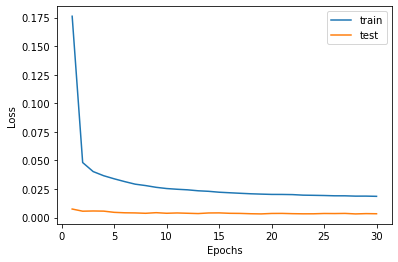

In [23]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [24]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:275]:INFO:starting testing in path: ./out
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:57]:INFO:total params: 4.31M
[lift.py:63]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:71]:INFO:ckpt loaded (epoch: 28 | err: 1.8557666005645266)
[lift.py:109]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/capture/out/test_results.pth.tar


In [25]:
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import camera_to_world
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)

assert len(test_cam_id) == 1
cam = read_cam(session_id, test_cam_id[0])
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

s = test_3d_gt.shape
test_3d_gt = camera_to_world(test_3d_gt.reshape(s[0], -1), cam['r'].T, cam['t']).reshape(s)
test_3d_pred = camera_to_world(test_3d_pred.reshape(s[0],-1), cam['r'].T, cam['t']).reshape(s)
#test_3d_pred[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan
test_3d_gt[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan

In [ ]:
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d
%matplotlib widget
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
i=100
plot_pose_3d(ax=ax, tar=test_3d_gt[i],
             pred=test_3d_pred[i],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"], 
            normalize=False, show_pred_always=True)      

origin = test_3d_gt[i][3]
print(origin)
ax.set_xlim(origin[0]-100, origin[0]+100)
ax.set_ylim(origin[1]-100, origin[1]+100)
ax.set_zlim(-100,25)

/home/user/Desktop/LiftPose3D/liftpose/plot.py:53: RuntimeWarning: Mean of empty slice
  pts = np.nanmean(tar,axis=0)
/home/user/Desktop/LiftPose3D/liftpose/plot.py:53: RuntimeWarning: Mean of empty slice
  pts = np.nanmean(tar,axis=0)
/home/user/Desktop/LiftPose3D/liftpose/plot.py:53: RuntimeWarning: Mean of empty slice
  pts = np.nanmean(tar,axis=0)
/home/user/Desktop/LiftPose3D/liftpose/plot.py:53: RuntimeWarning: Mean of empty slice
  pts = np.nanmean(tar,axis=0)
/home/user/Desktop/LiftPose3D/liftpose/plot.py:53: RuntimeWarning: Mean of empty slice
  pts = np.nanmean(tar,axis=0)
/home/user/Desktop/LiftPose3D/liftpose/plot.py:53: RuntimeWarning: Mean of empty slice
  pts = np.nanmean(tar,axis=0)
/home/user/Desktop/LiftPose3D/liftpose/plot.py:53: RuntimeWarning: Mean of empty slice
  pts = np.nanmean(tar,axis=0)
/home/user/Desktop/LiftPose3D/liftpose/plot.py:53: RuntimeWarning: Mean of empty slice
  pts = np.nanmean(tar,axis=0)
/home/user/Desktop/LiftPose3D/liftpose/plot.py:53: Runti

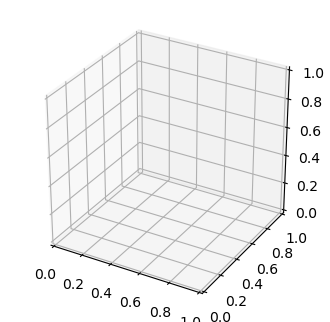

In [64]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
from celluloid import Camera
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

c = 0
for i in range(test_3d_gt.shape[0]):
    plot_pose_3d(ax=ax, tar=test_3d_gt[i],
                 pred=test_3d_pred[i],
                bones=par_data["vis"]["bones"], 
                limb_id=par_data["vis"]["limb_id"], 
                colors=par_data["vis"]["colors"], 
                normalize=False)
    origin = test_3d_gt[i][3]
    try:
        ax.set_xlim(origin[0]-100, origin[0]+100)
        ax.set_ylim(origin[1]-100, origin[1]+100)
        ax.set_zlim(-100,25)
        plt.savefig(f'out/pred{c}_missing.jpg')
        c += 1
    except:
        ax.clear()
        continue
    #camera.snap()
    ax.clear()

In [20]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

t = 50
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"],
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

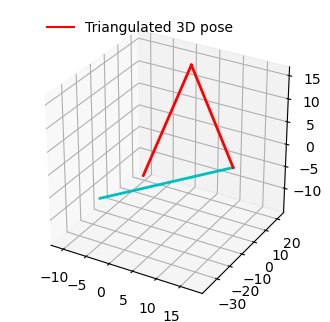

In [50]:
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.set_aspect('equal')
#ax.set_box_aspect([1,1,1])
#ax.view_init(elev=200, azim=60)
mat = read_data(0, 3)
pts3d = mat['data_3d'].reshape(-1,20,3)

plot_pose_3d(ax=ax, tar=pts3d[700],
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"], 
        colors=par_data["vis"]["colors"], 
        normalize=True)        

[animation.py:1112]:INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[animation.py:326]:DEBUG:frame size in pixels is 400 x 400
[animation.py:360]:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 400x400 -pix_fmt rgba -r 5.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y test.mp4
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBU

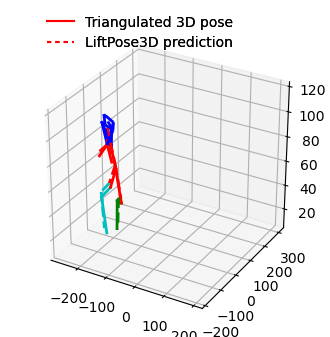

In [168]:
%matplotlib inline
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

camera = Camera(fig)
for t in range(0, 100):
    plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False)
    camera.snap()
camera.animate().save('test.mp4')

In [169]:
from IPython.display import Video
Video("test.mp4")

# Plot 2D

In [44]:
frame_id = 1141
idx = np.where(mat[0]['data_sampleID'] == frame_id)[0][0]

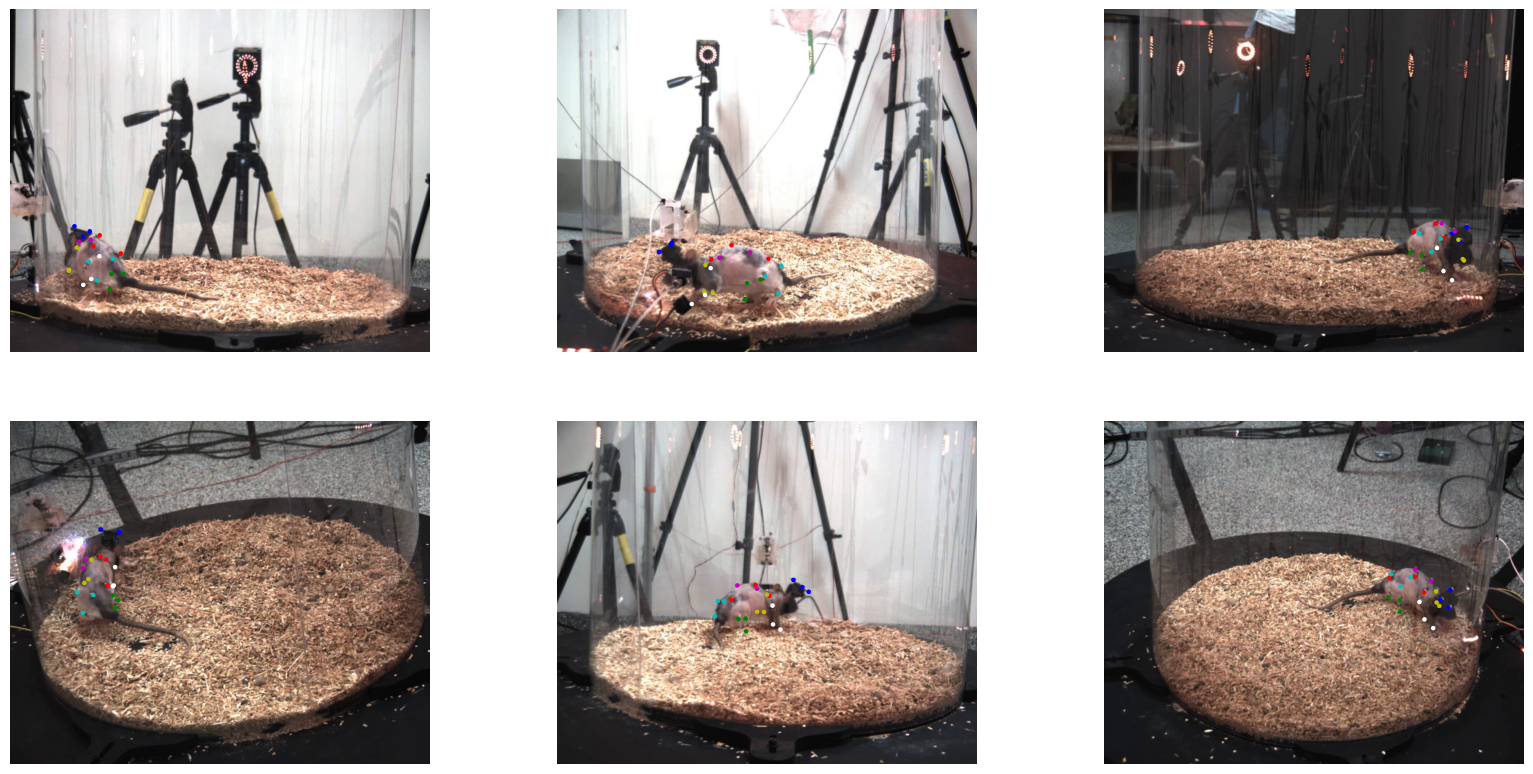

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(nrows=2, ncols=3, dpi=100, figsize=(20,10))
axs = np.ravel(np.array(axs))
for cam_id, ax in enumerate(axs):
    ax.imshow(plt.imread(f'images/sample0_{frame_id}_Camera{cam_list[cam_id]}.png'))
    pt = mat[cam_id]['data_2d'][idx].reshape(-1,2)
    ax.scatter(pt[:,0]-20, pt[:,1], c=marker_color[:20], s=5)
    ax.axis('off')

In [224]:
%matplotlib widget
par_data = yaml.full_load(open('param.yaml', "rb"))
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

ax.view_init(20,40)
i = 100
pts3d = mat[3]['data_3d'][i].reshape(-1,3)

for k in np.where(np.isnan(pts3d))[0]:
    pts3d[k] = pts3d[k-1]

plot_pose_3d(ax=ax, tar=pts3d,
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"], 
        colors=par_data["vis"]["colors"],
            normalize=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Check original dataset data

[animation.py:1112]:INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[animation.py:326]:DEBUG:frame size in pixels is 400 x 400
[animation.py:360]:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 400x400 -pix_fmt rgba -r 5.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y test2.mp4
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:377]:DEB

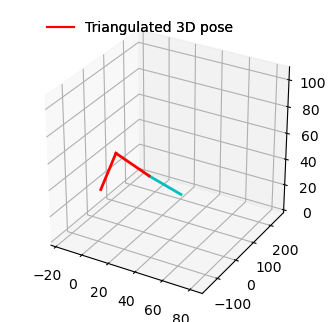

In [118]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
from celluloid import Camera
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.set_aspect('equal')
#ax.set_box_aspect([1,1,1])
#ax.view_init(elev=200, azim=60)
mat = read_data(0, 3)
camera = Camera(fig)

pts3d = mat['data_3d'].reshape(-1,20,3)[400:500]

for i in range(pts3d.shape[0]):
    plot_pose_3d(ax=ax, tar=pts3d[i],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"], 
            normalize=False, show_pred_always=True)        
    camera.snap()
    #ax.clear()

camera.animate().save('test2.mp4')

In [119]:
from IPython.display import Video
Video("test2.mp4")

Text(0, 0.5, 'Percentage')

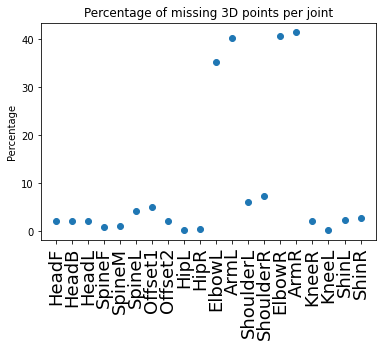

In [184]:
plt.title('Percentage of missing 3D points per joint')
plt.scatter(np.arange(20), np.sum(np.isnan(mat[5]['data_3d'].reshape(-1,20,3)),axis=(0,2))/3/mat[5]['data_3d'].shape[0] * 100)
plt.gca().set_xticks(range(20))
plt.gca().set_xticklabels([_[0] for _ in meta['markernames']], rotation='vertical', fontsize=18)
plt.ylabel('Percentage')

(0.0, 15.0)

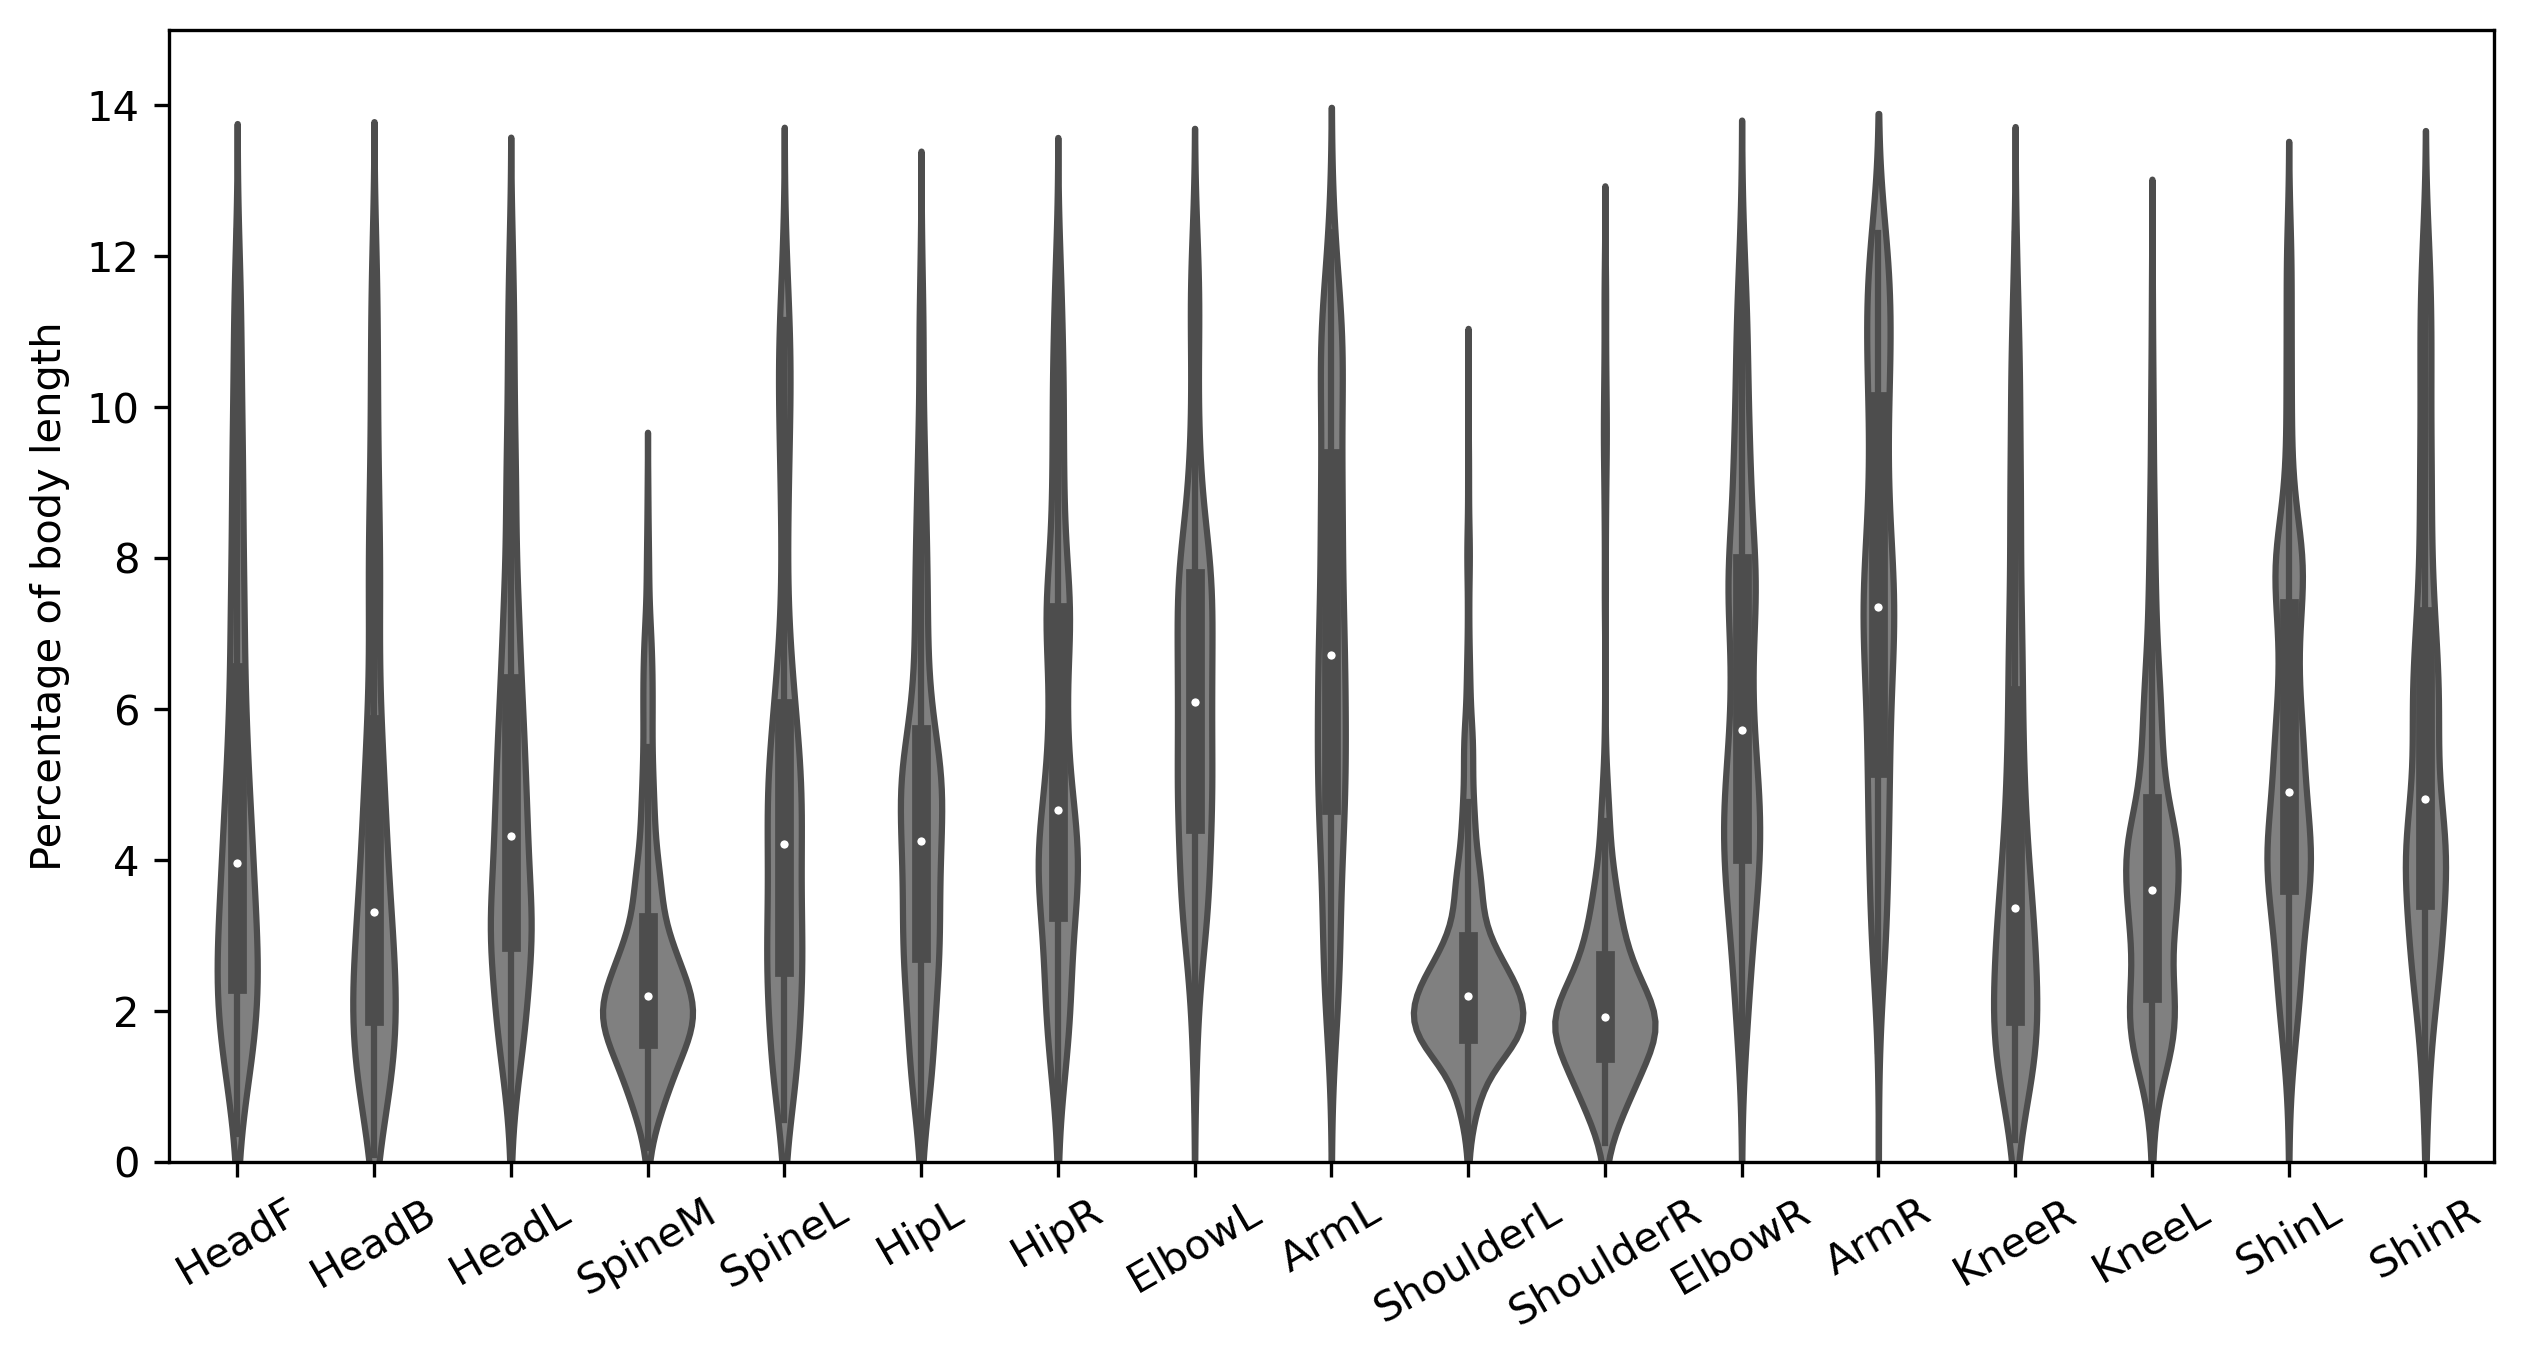

In [71]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

joints_name = par_data['vis']['names']
err_norm = np.sum(np.abs((test_3d_gt - test_3d_pred).reshape(test_3d_gt.shape[0], 20, 3)), axis=-1)
err_norm_sp = err_norm.copy()
joints_list = list()
    
for j in range(20):
    q = np.quantile(err_norm[:,j], 0.90)
    err_norm_sp[err_norm_sp[:,j] > q, j] = q

e_list = list()
n_list = list()
for i in range(err_norm_sp.shape[0]):
    for j in range(err_norm_sp.shape[1]):
        if not np.isnan(err_norm_sp[i,j]):
            if test_keypoints[i,j,0]:
                e_list.append(err_norm_sp[i,j] / 263.67092825261545 * 100)
                n_list.append(joints_name[j][0])

d = pd.DataFrame({"err":e_list, "joint": n_list})

q = d.quantile(q=0.95)
d = d.loc[d['err'] < q['err']]

plt.figure(dpi=300, figsize=(10,5))
plt.grid(False)
s = sns.violinplot(x="joint" , y="err", data=d, color='gray', order=order)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.xlabel('')
plt.ylabel('Percentage of body length')
plt.ylim([0,15])

In [66]:
order = ['HeadF',
         'HeadB',
         'HeadL',
         'SpineM',
         'SpineL',
         'HipL',
         'HipR',
         'ElbowL',
         'ArmL',
         'ShoulderL',
         'ShoulderR',
         'ElbowR',
         'ArmR',
         'KneeR',
         'KneeL',
         'ShinL',
         'ShinR']